# Notebook for FPL form vs fixtures analysis. 
Data can be downloaded at https://github.com/jcheong0428/jcheong0428.github.io/tree/master/assets/post20181226/FPL_form_v_fixture

In [326]:
%matplotlib inline
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, glob, os
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from patsy import Treatment

def find_minute_score(x):
    '''
    Adds points based on min played
    '''
    points = 0
    if x>0:
        points+=1
    if x>=60:
        points+=1
    return points

def bootstrap(vals,n=5000,pct=.95):
    '''
    returns deviance from mean to draw on barplot
    '''
    means = []
    for ix in range(0,5000):
        means.append(np.mean(np.random.choice(vals,len(vals),replace=True)))
    return np.sort(means)[int(n*(1-((1-pct)/2)))]-np.mean(means)


def calculate_gw_team_point(x): 
    '''
    calculate gameweek score earned 
    '''
    points = 0
    if (x.team_h_score > x.team_a_score) and x.was_home:
        points = 3
    elif (x.team_h_score < x.team_a_score) and not x.was_home:
        points = 3
    elif x.team_h_score == x.team_a_score:
        points = 1
    else: 
        points = 0
    return points

def find_previous_ranking(row): 
    '''
    Finds out opponent ranking by looking at opponent team's ranking from previous week. 
    Returns nan for first game week. 
    '''
    prev_team_ranking, opponent_ranking = np.nan,np.nan
    if row['round']>1:
        prev_round=row['round']-1
        this_team = row['team']
        opponent = row['opponent_team']
        try: 
            opponent_ranking = df_nona.query('round==@prev_round and team==@opponent')['team_ranking'].mode()[0]
            prev_team_ranking = df_nona.query('round==@prev_round and team==@this_team')['team_ranking'].mode()[0]
        except:
            try: 
                # go before round for missing gw
                prev_round = prev_round-1
                opponent_ranking = df_nona.query('round==@prev_round and team==@opponent')['team_ranking'].mode()[0]
                prev_team_ranking = df_nona.query('round==@prev_round and team==@this_team')['team_ranking'].mode()[0]
            except:
                print('error',prev_round,opponent)
    return prev_team_ranking, opponent_ranking

# This section looks at how the data was aggregated from the FPL repo. You can skip to the next section for the analyses.
Original data is from https://github.com/vaastav/Fantasy-Premier-League

In [545]:
season = '2016-17'

# import players_raw to figure out teams
players_raw = pd.read_csv(f'../Fantasy-Premier-League/data/{season}/players_raw.csv')
id_to_team = players_raw[['id','team']]

# season
if season == '2016-17':
    team_id_name = {1:"ARS", 2:"BOU", 3:"BUR", 4:"CHE", 5:"CRY", 6:"EVE", 7:"HUL", 8:"LEI", 9:"LIV", 10:"MCI", 
                    11:"MUN", 12:"MID", 13:"SOU", 14:"STO", 15:'SUD',16:"SWA", 17:"TOT", 18:"WAT", 19:"WBA", 20:"WHU"}
elif season =='2017-18':
    team_id_name = {1:"ARS", 2:"BOU", 3:"BRI", 4:"BUR", 5:"CHE", 6:"CRY", 7:"EVE", 8:"HUD", 9:"LEI", 10:"LIV", 
     11:"MCI", 12:"MUN", 13:"NEW", 14:"SOU", 15:"STO", 16:"SWA", 17:"TOT", 18:"WAT", 19:"WBA", 20:"WHU"}
elif season == '2018-19':
# 2018-2019
    team_id_name = {1:"ARS", 2:"BOU", 3:"BRI", 4:"BUR", 5:"CAR", 6:"CHE", 7:"CRY", 8:"EVE", 9:"FUL", 10:"HUD", 
     11:"LEI", 12:"LIV", 13:"MCI", 14:"MUN", 15:"NEW", 16:"SOU", 17:"TOT", 18:"WAT", 19:"WHU", 20:"WOL"}
else:
    print('NEED TEAM LIST')
   

In [546]:
player_dir = f'../Fantasy-Premier-League/data/{season}/players/'
players = glob.glob(os.path.join(player_dir,'*'))
df = pd.DataFrame()
for player in players:
    try:
        _df = pd.read_csv(os.path.join(player,'gw.csv'))
        pid = _df['element'][0]
        team_id = id_to_team.query('id==@pid')['team'].values[0]
        
        _df['player_name'] = os.path.split(player)[-1]
        _df['team'] = team_id
        _df['team_name'] = team_id_name[team_id]
        for form_n in [2,4,6]:
            _df[f'form{form_n}']=_df['total_points'].rolling(window=form_n).mean()
            for rowix, row in _df.iterrows():
                if np.isnan(row[f'form{form_n}']):
                    _df.loc[rowix,f'form{form_n}'] = _df.loc[_df.index[0]:rowix,'total_points'].mean()
            _df[f'form{form_n}'] = np.append(np.nan,_df[f'form{form_n}'].values)[:-1]
        # create column for previous form. 
        df = pd.concat([df,_df],axis=0)
    except:
        print(f'Error with {player}')
        pass
df_nona = df.sort_values(['player_name','round']).reset_index(drop=True)

In [547]:
# Calculate points earned each gw
df_nona['gw_team_point'] = df_nona.apply(lambda x: calculate_gw_team_point(x),axis=1)

df_nona['gw_team_cum_point'] = 0
for player in df_nona.player_name.unique():
    gw_team_cum_point = df_nona.query('player_name==@player').cumsum()['gw_team_point']
    df_nona.loc[gw_team_cum_point.index,'gw_team_cum_point'] = gw_team_cum_point
    
# for each round, do groupby 'team', and find mode value
gw_rankings_dict={}
for gw in range(1,df_nona['round'].max()+1):
    gw_df = df_nona.query('round==@gw')
    # ascending=True means Top of table would be ranked 20, as a difficulty ranking, and worst team as 1. 
    # ascending=False means rank on table, (e.g. MCI/LIV =1st)
    gw_rankings = pd.DataFrame(gw_df.groupby('team')['gw_team_cum_point'].apply(lambda x: x.mode()).rank(ascending=True))
    gw_rankings.index = gw_rankings.index.droplevel(1)
    gw_rankings.columns = ['epl_ranking']
    gw_rankings = gw_rankings.sort_values('epl_ranking',ascending=False)
#     Even style
#     gw_rankings.iloc[:5] = 5
#     gw_rankings.iloc[5:10] = 4
#     gw_rankings.iloc[10:15] = 3
#     gw_rankings.iloc[15:] = 2
#     FPL style
    gw_rankings.iloc[:2] = 5
    gw_rankings.iloc[2:6] = 4
    gw_rankings.iloc[6:12] = 3
    gw_rankings.iloc[12:] = 2
    gw_rankings_dict[gw] = gw_rankings.to_dict()['epl_ranking']

# calculate this week ranking
df_nona['team_ranking']  = df_nona.apply(lambda x: gw_rankings_dict[x['round']][x['team']],axis=1)

df_nona['opponent_ranking'] = np.nan
for (rowix, row) in df_nona.iterrows(): 
    prev_team_ranking, opponent_ranking = find_previous_ranking(row)
    df_nona.loc[rowix, 'opponent_ranking'] = opponent_ranking
    df_nona.loc[rowix, 'prev_team_ranking'] = prev_team_ranking
df_nona['team_ranking_diff'] = df_nona['prev_team_ranking']-df_nona['opponent_ranking'] # if I'm better, positive coefficients. 
df_nona['season'] = season


In [548]:
# figure out player position. 
df_nona['position'] = None
df_nona['minute_points']=df_nona['minutes'].apply(find_minute_score)
for player_name in df_nona.player_name.unique():
    _tempdf = df_nona.query('player_name==@player_name')
    if _tempdf['minutes'].median()>=60:
        if np.any(_tempdf['saves']>0):
            position = 'GK'
        else:
            clf = LinearRegression()
            X = _tempdf[['clean_sheets','assists','goals_scored','bonus','goals_conceded',
                             'minute_points','yellow_cards','red_cards','own_goals','penalties_missed']]
            clf.fit(X,_tempdf['total_points'].as_matrix())
            if clf.coef_[0]>2:
                position = "DF"
            if clf.coef_[0]>.5 and clf.coef_[0]<1.5:
                position = 'MF'
            if clf.coef_[0]<.5:
                position = 'FW'
        df_nona.loc[df_nona.player_name==player_name,'position']=position
df_nona.to_csv(f"player_{season}.csv",index=False)

In [549]:
fixture_df = pd.DataFrame()
for fixture in df_nona.fixture.unique():
    _fixture_df = df_nona.query('fixture==@fixture')
    team1, team2 = _fixture_df.groupby('team').count().sort_values('assists',ascending=False).iloc[:2].index.values
#     team1, team2 = _fixture_df.team.unique()
    df1 = pd.DataFrame(_fixture_df.query('team==@team1')[['round','team','opponent_team','prev_team_ranking','team_ranking_diff','opponent_ranking','was_home','team_h_score','team_a_score']].iloc[0]).T.reset_index()
    df2 = pd.DataFrame(_fixture_df.query('team==@team2')[['round','team','opponent_team','prev_team_ranking','team_ranking_diff','opponent_ranking','was_home','team_h_score','team_a_score']].iloc[0]).T.reset_index()
    fixture_df = pd.concat([fixture_df,df1,df2],ignore_index=True)
fixture_df['clean_sheets'] = fixture_df['was_home']*(fixture_df['team_a_score']==0) | ~fixture_df['was_home']*(fixture_df['team_h_score']==0)
fixture_df['goals_scored'] = fixture_df['was_home']*(fixture_df['team_h_score']>0) | ~fixture_df['was_home']*(fixture_df['team_a_score']>0)
fixture_df['season'] = season
fixture_df['team_name']=fixture_df['team'].apply(lambda x: team_id_name[x])
fixture_df.to_csv(f'fixture_{season}.csv', index=False)

# Load data combine 16-17 and 17-18 season

In [550]:
fixture_df = pd.DataFrame()
for season in ['2016-17', '2017-18']:
    fixture_df = pd.concat([fixture_df, pd.read_csv(f'fixture_{season}.csv')])

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be remove

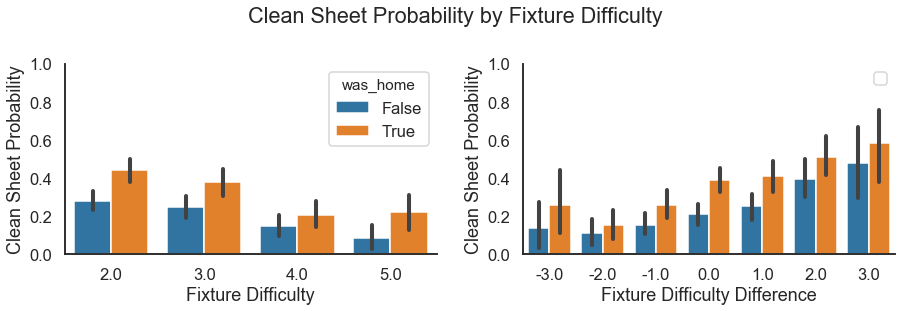

In [557]:
sns.set_context('talk')
sns.set_style('white')
y = 'clean_sheets'
f,ax=plt.subplots(1,2,figsize=(13,4))
g=sns.factorplot(x='opponent_ranking', y=y, hue='was_home',data=fixture_df,ci=95,kind='bar',aspect=1.5,ax=ax[0])
ax[0].set(ylim=[0,1.],xlabel='Fixture Difficulty',ylabel='Clean Sheet Probability')
plt.close(g.fig)
sns.despine()
g=sns.factorplot(x='team_ranking_diff', y=y, hue='was_home', data=fixture_df,ci=95,kind='bar',aspect=1.5,ax=ax[1])
ax[1].set(ylim=[0,1.],xlabel='Fixture Difficulty Difference',ylabel='Clean Sheet Probability')
plt.close(g.fig)
plt.legend([])
sns.despine()
plt.suptitle('Clean Sheet Probability by Fixture Difficulty',y=1.1)
plt.tight_layout()

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be remove

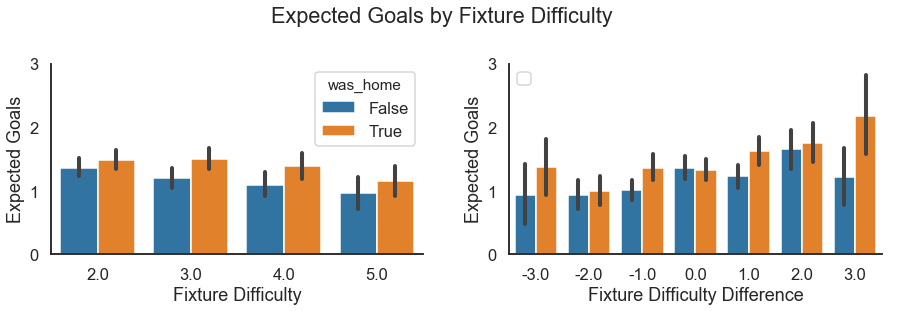

In [558]:
fixture_df['goals_scored_numeric']=np.nan
for rowix, row in fixture_df.iterrows():
    if row.was_home:
        fixture_df.loc[rowix,'goals_scored_numeric'] = row.team_h_score
    else:
        fixture_df.loc[rowix,'goals_scored_numeric'] = row.team_a_score  
        
y = 'goals_scored_numeric'
f,ax=plt.subplots(1,2,figsize=(13,4))
g=sns.factorplot(x='opponent_ranking', y=y, hue='was_home',data=fixture_df,ci=95,kind='bar',aspect=1.5,ax=ax[0])
ax[0].set(ylim=[0,3.],xlabel='Fixture Difficulty',ylabel='Expected Goals')
plt.close(g.fig)
sns.despine()
g=sns.factorplot(x='team_ranking_diff', y=y, hue='was_home', data=fixture_df,ci=95,kind='bar',aspect=1.5,ax=ax[1])
ax[1].set(ylim=[0,3.],xlabel='Fixture Difficulty Difference',ylabel='Expected Goals')
plt.close(g.fig)
plt.legend([])
sns.despine()
plt.suptitle('Expected Goals by Fixture Difficulty',y=1.1)
plt.tight_layout()

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be remove

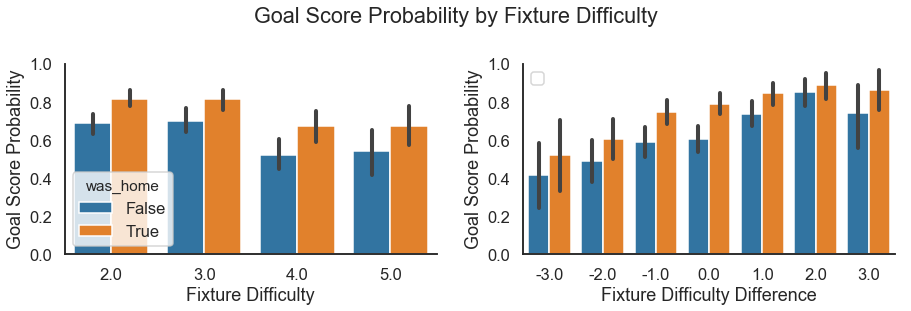

In [559]:
y = 'goals_scored'
f,ax=plt.subplots(1,2,figsize=(13,4))
g=sns.factorplot(x='opponent_ranking', y=y, hue='was_home',data=fixture_df,ci=95,kind='bar',aspect=1.5,ax=ax[0])
ax[0].set(ylim=[0,1.],xlabel='Fixture Difficulty',ylabel='Goal Score Probability')
plt.close(g.fig)
sns.despine()
g=sns.factorplot(x='team_ranking_diff', y=y, hue='was_home', data=fixture_df,ci=95,kind='bar',aspect=1.5,ax=ax[1])
ax[1].set(ylim=[0,1.],xlabel='Fixture Difficulty Difference',ylabel='Goal Score Probability')
plt.close(g.fig)
plt.legend([])
sns.despine()
plt.suptitle('Goal Score Probability by Fixture Difficulty',y=1.1)
plt.tight_layout()

In [451]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),size=18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
kf = RepeatedKFold(n_splits=5, n_repeats = 20)
X = fixture_df.dropna()[['prev_team_ranking','opponent_ranking','was_home']].as_matrix()
y = fixture_df.dropna()[['clean_sheets']].as_matrix().ravel()

scores, cnf_matrices = [],[]
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LogisticRegression(solver='lbfgs',class_weight='balanced')
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    scores.append(score)
    cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    cnf_matrices.append(cnf_matrix)

f,axes = plt.subplots(1,2, figsize=(10,5))
sns.stripplot(scores,orient='v',color='k',ax=axes[0])
sns.barplot(scores,orient='v',ax=axes[0])
average_score = np.round(np.mean(scores),2)
axes[0].set(title=f'Clean Sheet Prediction\nAverage Accuracy {average_score}', ylabel='Accuracy',ylim=[.5,.8])
plot_confusion_matrix(np.array(cnf_matrices).sum(axis=0),classes=clf.classes_,normalize=True,cmap=plt.cm.RdBu,title='Clean Sheet Prediction\nConfusion Matrix')
sns.despine()

# player df

In [507]:
from sklearn import preprocessing

def plot_prediction_results(X,y, cols2use=cols2use,y_col=y_col):
    kf = RepeatedKFold(n_splits=5, n_repeats = 20)
    scores, cnf_matrices, coefs = [], [],[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scaler = preprocessing.StandardScaler().fit(X_train)
        clf = LogisticRegression(solver='lbfgs',class_weight='balanced')
        clf.fit(scaler.transform(X_train),y_train)
        score = clf.score(scaler.transform(X_test),y_test)
        scores.append(score)
        cnf_matrix = confusion_matrix(y_test, clf.predict(scaler.transform(X_test)))
        cnf_matrices.append(cnf_matrix)
        coefs.append(clf.coef_[0])
    f,axes = plt.subplots(1,3, figsize=(20,5))
    coefs_df = pd.DataFrame(np.array(coefs), columns = cols2use)
    coefs_df = coefs_df.melt(var_name='Variable', value_name='Beta')
    coefs_df = coefs_df.replace({'team_ranking_diff':'Fixture Difficulty\nDifference','form6': "Form"})
    sns.barplot(x ='Variable',y='Beta',data=coefs_df, ax = axes[0])
    axes[0].set(title=f"Coefficient Weights")

    sns.stripplot(scores,orient='v',color='k',ax=axes[1])
    sns.barplot(scores,orient='v',ax=axes[1])
    average_score = np.round(np.mean(scores),2)
    axes[1].set(title=f"Prediction Average Accuracy {average_score}", ylabel='Accuracy',ylim=[.5,1])

    plot_confusion_matrix(np.array(cnf_matrices).sum(axis=0),classes=clf.classes_,normalize=True,cmap=plt.cm.RdBu,title=f" Prediction Confusion Matrix")
    plt.suptitle(f"{y_col}",y=1.02)
    plt.tight_layout()
    sns.despine()
    plt.show()

In [185]:
player_df = pd.DataFrame()
for season in ['2016-17', '2017-18']:
    player_df = pd.concat([player_df, pd.read_csv(f'player_{season}.csv')])

In [483]:
sns.set_context('talk')

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Normalized confusion matrix
[[0.58026883 0.41973117]
 [0.41673729 0.58326271]]


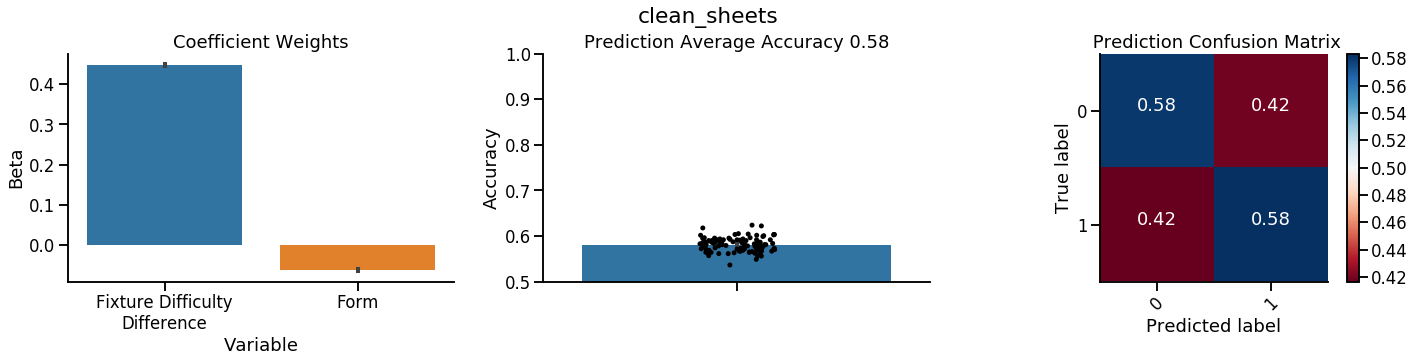

In [512]:
queried_df = player_df.query('round!=1 and minutes>=60 and (position=="DF" or position=="GK")')
cols2use = ['team_ranking_diff','form6']
y_col = 'clean_sheets'
X = queried_df.dropna()[cols2use].as_matrix()
y = queried_df.dropna()[[y_col]].as_matrix().ravel()
plot_prediction_results(X,y, cols2use=cols2use,y_col=y_col)


/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

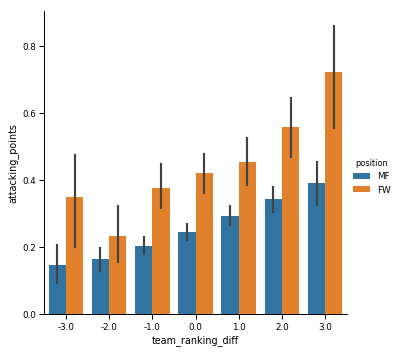

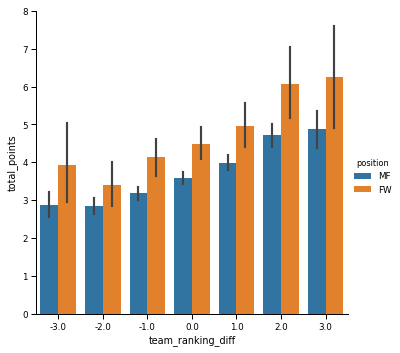

In [436]:
queried_df = player_df.query('round!=1 and minutes>=60 and (position=="MF" or position=="FW")')
queried_df['attacking_points'] = queried_df[['assists','goals_scored']].sum(axis=1)>0
sns.factorplot(x='team_ranking_diff',y='attacking_points',hue='position',data = queried_df,kind='bar',ci=95)
sns.factorplot(x='team_ranking_diff',y='total_points',hue='position',data = queried_df,kind='bar',ci=95)

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Normalized confusion matrix
[[0.64489367 0.35510633]
 [0.44653342 0.55346658]]


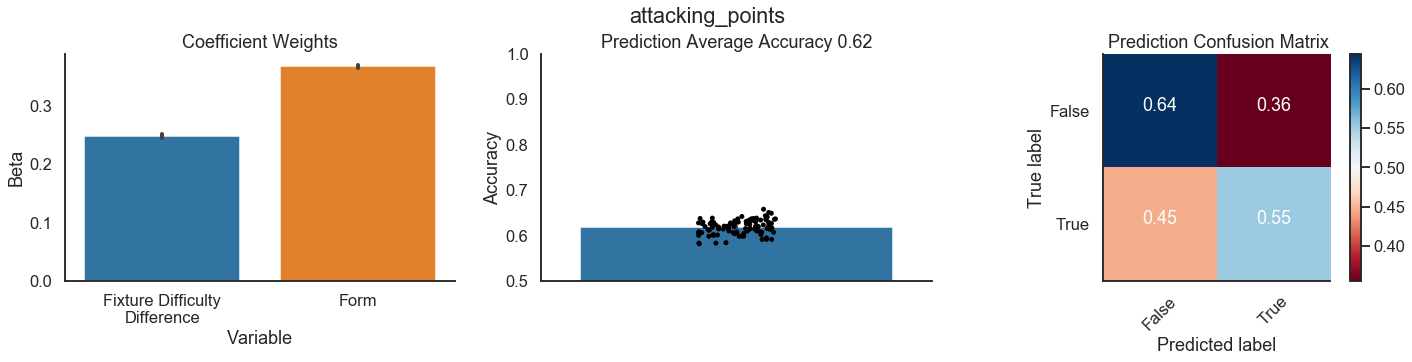

In [530]:
sns.set_context('talk')
queried_df = player_df.query('round!=1 and minutes>=60 and (position=="MF" or position=="FW")')
queried_df['attacking_points'] = queried_df[['assists','goals_scored']].sum(axis=1)>0
cols2use = ['team_ranking_diff','form6']
y_col = 'attacking_points'
X = queried_df.dropna()[cols2use].as_matrix()
y = queried_df.dropna()[[y_col]].as_matrix().ravel()
plot_prediction_results(X,y, cols2use=cols2use,y_col=y_col)

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Normalized confusion matrix
[[0.84078882 0.15921118]
 [0.20387258 0.79612742]]


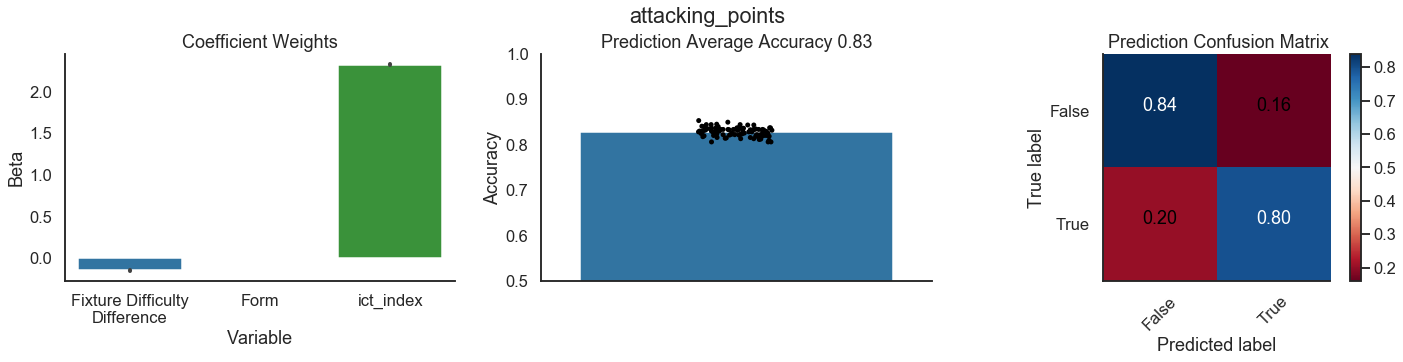

In [531]:
queried_df = player_df.query('round!=1 and minutes>=60 and (position=="MF" or position=="FW")')
queried_df['attacking_points'] = queried_df[['assists','goals_scored']].sum(axis=1)>0
cols2use = ['team_ranking_diff','form6','ict_index']
y_col = 'attacking_points'
X = queried_df.dropna()[cols2use].as_matrix()
y = queried_df.dropna()[[y_col]].as_matrix().ravel()
plot_prediction_results(X,y, cols2use=cols2use,y_col=y_col)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13509ddd8>,
      dtype=object)

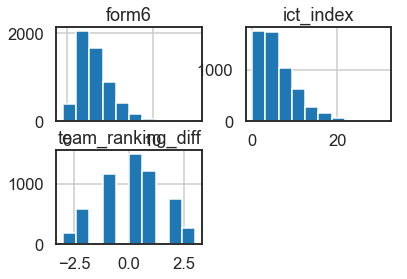

In [536]:
queried_df.dropna()[cols2use].hist()